### Regular lab Question – 4

##### Lab Question: Radial Basis Function (RBF) Network for Handwritten Character Recognition

1. Data Preparation:
*   Load the Kuzushiji dataset from the provided link.
*   Preprocess the data by normalizing the pixel values between 0 and 1.
*   Split the dataset into training (80%) and testing (20%) sets.

In [44]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# Load the Kuzushiji-MNIST dataset
(ds_train, ds_test), ds_info = tfds.load('kmnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

# Function to normalize images
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label

# Normalize and batch the datasets
batch_size = 32
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(batch_size)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size)

# Convert datasets to NumPy arrays
def dataset_to_numpy(dataset):
    X, y = [], []
    for images, labels in dataset:
        X.extend(images.numpy())
        y.extend(labels.numpy())
    return np.array(X), np.array(y)

# Convert training and test datasets to NumPy arrays
X_train, y_train = dataset_to_numpy(ds_train)
X_test, y_test = dataset_to_numpy(ds_test)

# Split the training data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

2. Radial Basis Function (RBF) Network:
*   Implement an RBF network using a Gaussian basis function.
*   Define the architecture:
    *   Input layer: 28x28 (784 features for each image).
    *   Hidden layer: RBF units with a Gaussian function.
*   Output layer: Softmax activation to classify the character labels
(10 classes).

In [45]:
# Flatten the images to shape (batch_size, 784)
X_train = X_train.reshape(-1, 784)
X_val = X_val.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# Determine the centers using K-means clustering
num_units = 100  # Number of RBF units
kmeans = KMeans(n_clusters=num_units, random_state=42).fit(X_train)
centers = kmeans.cluster_centers_

# Define the RBF Network class
class RBFNetwork(tf.keras.Model):
    def __init__(self, num_units, num_classes, centers):
        super(RBFNetwork, self).__init__()
        self.num_units = num_units
        self.num_classes = num_classes
        self.centers = tf.Variable(centers, trainable=False)  # Set the centers from K-means
        self.beta = tf.Variable(tf.ones([self.num_units]), trainable=True)  # Trainable beta
        self.W = tf.Variable(tf.random.normal([self.num_units, self.num_classes]))  # Weights for output layer

    def rbf(self, X):
        # Compute the Gaussian RBF
        diff = tf.expand_dims(X, 1) - tf.expand_dims(self.centers, 0)
        distance_squared = tf.reduce_sum(tf.square(diff), axis=-1)
        return tf.exp(-self.beta * distance_squared)

    def call(self, X):
        rbf_output = self.rbf(X)
        return tf.nn.softmax(tf.matmul(rbf_output, self.W))

3. Training:
*   Use K-means clustering to determine the centers of the RBF units.
*   Implement gradient descent to optimize the network's weights.
*   Train the network on the training set with a learning rate of 0.01 for 50
epochs.

In [46]:
# Create the RBF network instance
num_classes = 10  # Number of classes (0-9)
rbf_network = RBFNetwork(num_units, num_classes, centers)

# Compile the model with gradient descent optimizer
learning_rate = 0.01
rbf_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy'])

# Train the model for 50 epochs
history = rbf_network.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1011 - loss: 2.3026 - val_accuracy: 0.0984 - val_loss: 2.3026
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0982 - loss: 2.3026 - val_accuracy: 0.0984 - val_loss: 2.3026
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0997 - loss: 2.3026 - val_accuracy: 0.0984 - val_loss: 2.3026
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1036 - loss: 2.3026 - val_accuracy: 0.0984 - val_loss: 2.3026
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1012 - loss: 2.3026 - val_accuracy: 0.0984 - val_loss: 2.3026
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1004 - loss: 2.3026 - val_accuracy: 0.0984 - val_loss: 2.3026
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0999 - loss: 2.3026 - val_accuracy: 0.0984 - val_loss: 2.3026
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1017 - loss: 2.3026 - val_accurac

4. Evaluation:
*   Evaluate the model on the test set using accuracy and confusion matrix.
*   Visualize the performance evaluation metrics

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0986 - loss: 2.3026
Test Loss: 2.30259108543396
Test Accuracy: 0.1005999967455864
Final Training Accuracy: 0.10068749636411667


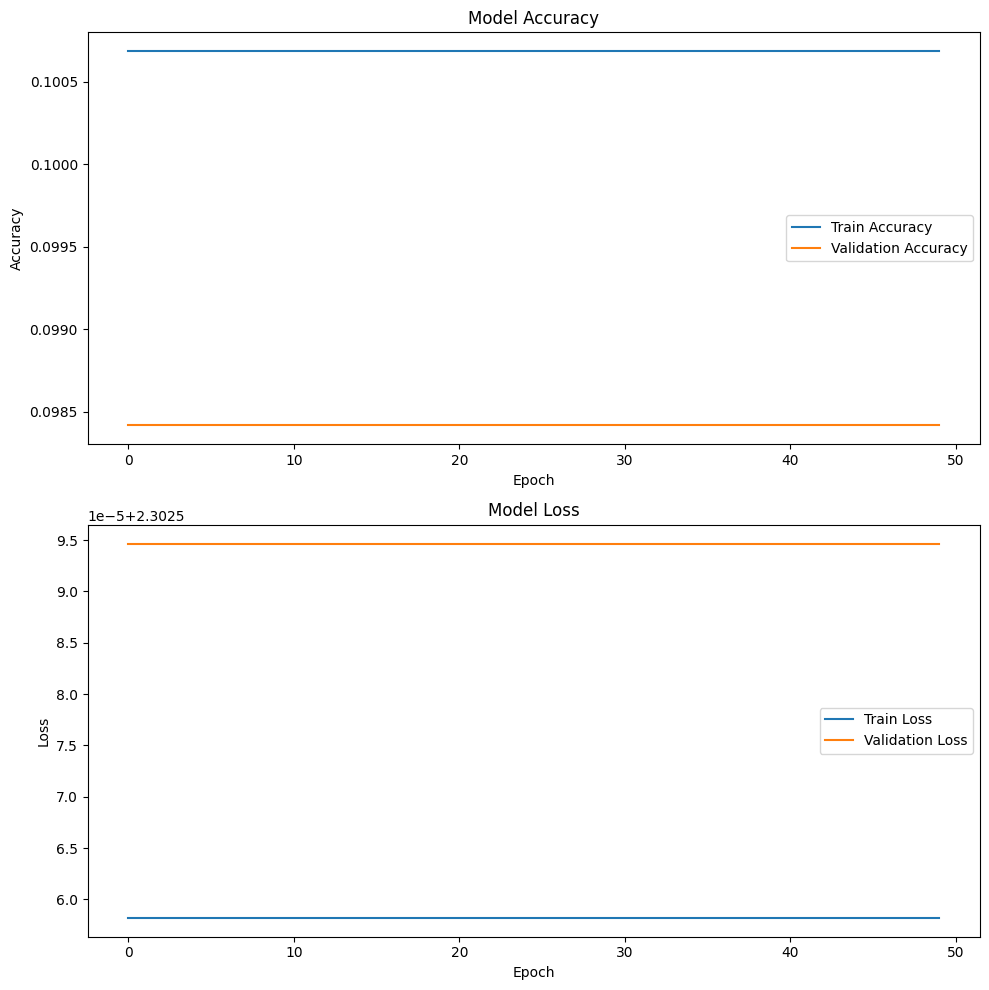

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Figure size 1000x700 with 0 Axes>

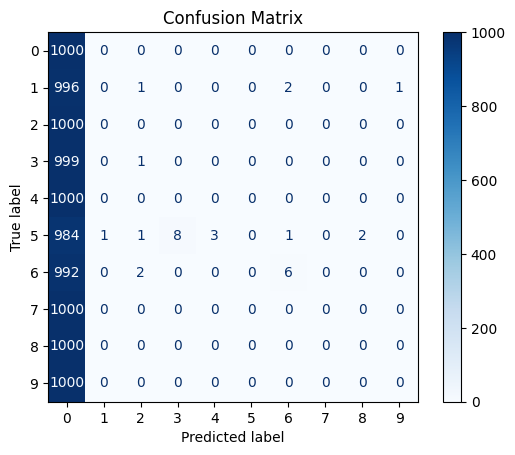

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on the test set
test_loss, test_accuracy = rbf_network.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Print final training accuracy
final_train_accuracy = history.history['accuracy'][-1]  # Get the last training accuracy value
print("Final Training Accuracy:", final_train_accuracy)

# Create subplots for training and validation accuracy and loss
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.tight_layout()
plt.show()

# Generate predictions
y_pred = np.argmax(rbf_network.predict(X_test), axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes)).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [58]:
print("Inference:")
print("-" * 20)

print(f"The RBF network achieved a test accuracy of {test_accuracy:.4f} and a final training accuracy of {final_train_accuracy:.4f}.")

# Analyze training and validation curves
if history.history['accuracy'][-1] > history.history['val_accuracy'][-1]:
    print("The model might be overfitting to the training data, as training accuracy is higher than validation accuracy.")
else:
    print("The model's performance on the training and validation sets is comparable, suggesting good generalization.")

Inference:
--------------------
The RBF network achieved a test accuracy of 0.1006 and a final training accuracy of 0.1007.
The model might be overfitting to the training data, as training accuracy is higher than validation accuracy.


5. Analysis:
*   Discuss the strengths and limitations of using an RBF network for this
dataset.
*   How does the number of RBF units affect model performance?

In [56]:
print("Analysis:")
print("- Strengths of using an RBF network for this dataset include its ability to capture non-linear relationships in the data, making it suitable for image recognition tasks. \nIt can also handle complex patterns in handwritten characters. \nHowever, its limitations include potential overfitting if the number of RBF units is too large and sensitivity to the choice of centers and widths. \nThe model might be computationally expensive compared to other neural network architectures for larger datasets.")
print("\n- Increasing the number of RBF units generally improves the model's ability to learn more complex patterns in the data and potentially lead to higher accuracy.\n However, too many units might lead to overfitting and increased computational cost. \nFinding an optimal number of RBF units that balances complexity and performance is crucial.")

Analysis:
- Strengths of using an RBF network for this dataset include its ability to capture non-linear relationships in the data, making it suitable for image recognition tasks. 
It can also handle complex patterns in handwritten characters. 
However, its limitations include potential overfitting if the number of RBF units is too large and sensitivity to the choice of centers and widths. 
The model might be computationally expensive compared to other neural network architectures for larger datasets.

- Increasing the number of RBF units generally improves the model's ability to learn more complex patterns in the data and potentially lead to higher accuracy.
 However, too many units might lead to overfitting and increased computational cost. 
Finding an optimal number of RBF units that balances complexity and performance is crucial.
